In [1]:

from PIL import Image
import numpy as np
import glob
import regex 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier


In [2]:



def read_dataset(path):
  data= np.zeros([400,10305])
  i=0
  images_list = []
  for filename in glob.glob(path+"/*/*.pgm"): 
    im=Image.open(filename)
    images_list.append(im)
    l=regex.split(r'/', filename)
    l2= regex.split(r's', l[1])
    arr = np.array(im)
    data[i,0:10304]=arr.reshape(1,10304)
    data[i, -1]=l2[1]
    i+=1
  return data, images_list

    

In [3]:
def data_splitting():
    test_X = np.zeros([200,10304])
    train_X = np.zeros([200,10304])
    test_y= np.zeros(200)
    train_y=np.zeros(200)
    for i in range(data.shape[0]):
        if i%2 == 0:
            test_X[int(i/2)]=data[i,:-1]
            test_y[int(i/2)]= data[i,-1]
        else:
            train_X[int((i-1)/2)]=data[i,:-1]
            train_y[int((i-1)/2)]= data[i,-1] 
    return train_X, train_y, test_X, test_y


In [4]:
def trained_data_splitting(x):
    rows,cols=x.shape
    test_X = np.zeros([200,cols])
    train_X = np.zeros([200,cols])
    for i in range(x.shape[0]):
        if i%2 == 0:
            test_X[int(i/2)]=x[i,:]
        else:
            train_X[int((i-1)/2)]=x[i,:]
    return train_X, test_X



In [5]:
def visualize(images,i):
  plt.imshow(images[i])
  

In [6]:
data, images= read_dataset("orl_faces") 
train_x, train_y, test_x, test_y= data_splitting()
#print(train_y)
#visualize(images, 32)

In [7]:
def FOTV(eig_vals,totVar,alphas):
    I=dict()
    for alpha in alphas:
        expVar=0.0
        i=0
        while expVar <= (alpha * totVar): 
            expVar+=eig_vals[i]
            i+=1
        I[alpha]=i
    return I

In [8]:
def pCA(dataMatrix):
    transformed=dict()
    X=dataMatrix[:,:]
    num_data, dim = X.shape
    mean_X = X.mean(axis=0)
    X = X - mean_X 
    cov_mat = np.dot(X.T, X)/(num_data) # covariance matrix
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    totVar = sum(eig_vals)
    idx = eig_vals.argsort()[::-1]   
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]
    num = FOTV(eig_vals,totVar,[0.8,0.85,0.9,0.95])
    for key, vals in num.items(): 
        reducedVec=eig_vecs[:vals,:]
        transformed[key]=np.absolute(X.dot(reducedVec.T))
        print(len(transformed))
    return transformed

In [9]:
x=pCA(data[:][:-1])

1
2
3
4


In [10]:
def kmodel_score(train_X, test_X,neighbors):
    knn_model = KNeighborsClassifier(n_neighbors=neighbors)
    knn_model.fit(train_X, train_y) 
    y_predict = knn_model.score(test_X,test_y)
    return(y_predict)

In [11]:
info={}
for key, vals in x.items(): 
    train_X, test_X=trained_data_splitting(vals)
    score=kmodel_score(train_X, test_X,1)
    info[key]=score
    print(key,score)  

0.8 0.765
0.85 0.83
0.9 0.88
0.95 0.895


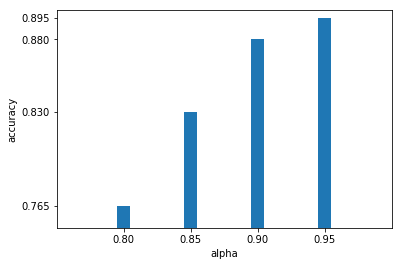

In [44]:
keys = list(info.keys())
vals = list(info.values())

plt.bar(keys,vals,align='center',width=0.01)
plt.ylim(0.75,0.9)
plt.ylabel ('accuracy')
plt.yticks(list(vals))
plt.xlabel ('alpha')
plt.xlim(0.75,1)
plt.xticks(list(keys))
plt.savefig('pcaAccuracy.png')
plt.show()


In [19]:
def pca():
  pca = PCA(n_components= 200)
  pca_model= pca.fit(train_x)
  new_dimensions = pca_model.transform(train_x)  
  #plt.scatter(new_dimensions[:,0],new_dimensions[:,1])  
  #print(pca.explained_variance_ratio_)  
  #print(new_dimensions.shape)
  #print(pca.explained_variance_ratio_)
  return  new_dimensions

new_dimensions= pca()


In [14]:
PCA(train_x)

PCA(copy=True, iterated_power='auto',
  n_components=array([[ 24.,  26., ..., 180., 178.],
       [ 22.,  19., ..., 158., 166.],
       ...,
       [126., 124., ...,  81.,  78.],
       [128., 123., ...,  77.,  83.]]),
  random_state=None, svd_solver='auto', tol=0.0, whiten=False)